In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import copy

In [2]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    cache = Z
    
    return A, cache

def reluBackward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoidBackward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def softmaxBackward(dA, activation_cache):
    Z = activation_cache
    dZ = dA
    return dZ

In [1]:
def initializeParametersHE(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])*np.sqrt(2/layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [17]:
def linearForward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

def linearActivationForward(A_prev, W, b, activation):
    Z, linear_cache = linearForward(A_prev, W, b)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

def LModelForward(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2
    
    for l in range(1, L):
        A_prev = A
        
        A, cache = linearActivationForward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = 'relu')
        caches.append(cache)
        
    AL, cache = linearActivationForward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = 'sigmoid')
    caches.append(cache)
    
    return AL, caches

In [5]:
def computeCost(AL, Y):
    m = Y.shape[1]
    
    cost = -(np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL))))/m
    cost = np.squeeze(cost)
    
    return cost

In [16]:
def linearBackward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ)
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    
    return dA_prev, dW, db

def linearActivationBackward(dA, cache, activation):
    linear_cache, activation_cache = cache 
    
    if activation == 'sigmoid':
        dZ = sigmoidBackward(dA, activation_cache)
    elif activation == 'relu':
        dZ = reluBackward(dA, activation_cache)
    elif activation == 'softmax':
        dZ = softmaxBackward(dA, activation_cache)
        
    dA_prev, dW, db = linearBackward(dZ, linear_cache)
    
    return dA_prev, dW, db

def LModelBackward(AL, Y, caches):
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    grads = {}
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    dA_prev_temp, dW_temp, db_temp = linearActivationBackward(dAL, current_cache, activation = "sigmoid")
    grads["dA" + str(L - 1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linearActivationBackward(grads["dA" + str(l + 1)], current_cache, activation='relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

In [7]:
def updateParameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate*grads["db" + str(l + 1)]
        
    return parameters

In [18]:
def L_LayeredModel(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    costs = []
    
    parameters = initializeParametersHE(layer_dims)
    
    for i in range(0, num_iterations):
        AL, caches = LModelForward(X, parameters)
        cost = computeCost(AL, Y)
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            
            Y_pred_train = predict(X, parameters)
            accuracy = np.mean(Y_pred_train == np.argmax(Y, axis=0)) * 100
            print("Train Accuracy after iteration {}: {}%".format(i, round(accuracy, 5)))
            
            Y_pred_test = predict(X_test, parameters)
            accuracy = np.mean(Y_pred_test == np.argmax(Y_test, axis=0)) * 100
            print("Test Accuracy after iteration {}: {}%".format(i, round(accuracy, 5)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
            
        grads = LModelBackward(AL, Y, caches=caches)
        parameters = updateParameters(parameters, grads, learning_rate)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title(f"Learning rate = {learning_rate}")
    plt.show()
            
    return parameters, costs

def predict(X, parameters):
    AL, _ = LModelForward(X, parameters)
    return np.argmax(AL, axis=0)

In [9]:
def read_images_from_folders(folder_paths):
    images = []
    
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    
    return images

In [10]:
folder_paths = ["C:\\Users\\ASMITPAUL\\Downloads\\train\\moe_szyslak", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\ned_flanders", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\principal_skinner", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\bart_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\charles_montgomery_burns", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\homer_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\krusty_the_clown", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\lisa_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\marge_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\train\\milhouse_van_houten"]

image_matrices = read_images_from_folders(folder_paths)

image_array = np.array(image_matrices)

print("Shape of the image array:", image_array.shape)

X_train = image_array.reshape(image_array.shape[0], -1).T/255.0

Shape of the image array: (8000, 28, 28)


In [11]:

Y_train =   [[[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]*800 +
            [[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]*800 +
            [[0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]*800 +
            [[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]]*800 +
            [[0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]]*800 +
            [[0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]]*800 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]]*800 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]]*800 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]]*800 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]]*800]
        
Y_train = np.array(Y_train)
Y_train = np.squeeze(Y_train)
Y_train.shape
Y_train = Y_train.T

In [12]:
folder_paths = ["C:\\Users\\ASMITPAUL\\Downloads\\test\\moe_szyslak", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\ned_flanders", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\principal_skinner", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\bart_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\charles_montgomery_burns", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\homer_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\krusty_the_clown", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\lisa_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\marge_simpson", 
                "C:\\Users\\ASMITPAUL\\Downloads\\test\\milhouse_van_houten"]

image_matrices = read_images_from_folders(folder_paths)

image_array = np.array(image_matrices)

print("Shape of the image array:", image_array.shape)

X_test = image_array.reshape(image_array.shape[0], -1).T/255.0

Shape of the image array: (2000, 28, 28)


In [13]:
Y_test =   [[[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]*200 +
            [[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]*200 +
            [[0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]*200 +
            [[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]]*200 +
            [[0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]]*200 +
            [[0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]]*200 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]]*200 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]]*200 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]]*200 +
            [[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]]*200]
        
Y_test = np.array(Y_test)
Y_test = np.squeeze(Y_test)
Y_test.shape
Y_test = Y_test.T

In [14]:
folder_paths = ["C:\\Users\\ASMITPAUL\\Downloads\\test_bonus"]

image_matrices = read_images_from_folders(folder_paths)

image_array = np.array(image_matrices)

print("Shape of the image array:", image_array.shape)

X_test_bonus = image_array.reshape(image_array.shape[0], -1).T/255.0

Shape of the image array: (10, 28, 28)


Cost after iteration 0: 6.926576275028
Train Accuracy after iteration 0: 10.4375%
Test Accuracy after iteration 0: 9.5%
Cost after iteration 100: 3.3681930096193655
Train Accuracy after iteration 100: 10.125%
Test Accuracy after iteration 100: 10.0%
Cost after iteration 200: 3.3499927359472492
Train Accuracy after iteration 200: 10.675%
Test Accuracy after iteration 200: 10.6%
Cost after iteration 300: 3.3319345755767134
Train Accuracy after iteration 300: 11.8875%
Test Accuracy after iteration 300: 11.75%
Cost after iteration 400: 3.310950772731207
Train Accuracy after iteration 400: 14.5125%
Test Accuracy after iteration 400: 15.2%
Cost after iteration 500: 3.285229191662192
Train Accuracy after iteration 500: 19.7375%
Test Accuracy after iteration 500: 19.05%
Cost after iteration 600: 3.255513556486716
Train Accuracy after iteration 600: 22.1875%
Test Accuracy after iteration 600: 21.55%
Cost after iteration 700: 3.2256604861144913
Train Accuracy after iteration 700: 23.05%
Test Acc

Cost after iteration 6200: 2.578867885829022
Train Accuracy after iteration 6200: 44.6375%
Test Accuracy after iteration 6200: 33.85%
Cost after iteration 6300: 2.56865209874086
Train Accuracy after iteration 6300: 44.9625%
Test Accuracy after iteration 6300: 33.9%
Cost after iteration 6400: 2.5590322757610737
Train Accuracy after iteration 6400: 45.225%
Test Accuracy after iteration 6400: 33.9%
Cost after iteration 6500: 2.54944092815245
Train Accuracy after iteration 6500: 45.575%
Test Accuracy after iteration 6500: 34.45%
Cost after iteration 6600: 2.540037995956064
Train Accuracy after iteration 6600: 45.825%
Test Accuracy after iteration 6600: 34.5%
Cost after iteration 6700: 2.5299883045927607
Train Accuracy after iteration 6700: 46.0875%
Test Accuracy after iteration 6700: 34.65%
Cost after iteration 6800: 2.519794353554791
Train Accuracy after iteration 6800: 46.425%
Test Accuracy after iteration 6800: 34.7%
Cost after iteration 6900: 2.5102678088953168
Train Accuracy after ite

Cost after iteration 12300: 2.000946013842152
Train Accuracy after iteration 12300: 61.575%
Test Accuracy after iteration 12300: 36.0%
Cost after iteration 12400: 2.019572559238868
Train Accuracy after iteration 12400: 60.2375%
Test Accuracy after iteration 12400: 34.25%
Cost after iteration 12500: 1.9951345831160612
Train Accuracy after iteration 12500: 61.25%
Test Accuracy after iteration 12500: 34.45%
Cost after iteration 12600: 1.9891113890161218
Train Accuracy after iteration 12600: 61.2875%
Test Accuracy after iteration 12600: 35.7%
Cost after iteration 12700: 1.9838703305932583
Train Accuracy after iteration 12700: 62.0125%
Test Accuracy after iteration 12700: 36.65%
Cost after iteration 12800: 1.9847001076058124
Train Accuracy after iteration 12800: 62.0625%
Test Accuracy after iteration 12800: 35.85%
Cost after iteration 12900: 1.9913257611986372
Train Accuracy after iteration 12900: 60.675%
Test Accuracy after iteration 12900: 35.7%
Cost after iteration 13000: 1.9543645262323

Cost after iteration 18300: 1.5232667126537236
Train Accuracy after iteration 18300: 74.8375%
Test Accuracy after iteration 18300: 39.65%
Cost after iteration 18400: 1.4954191135433896
Train Accuracy after iteration 18400: 75.25%
Test Accuracy after iteration 18400: 38.5%
Cost after iteration 18500: 1.5178949611943184
Train Accuracy after iteration 18500: 75.9875%
Test Accuracy after iteration 18500: 39.15%
Cost after iteration 18600: 1.4903216826913348
Train Accuracy after iteration 18600: 75.6125%
Test Accuracy after iteration 18600: 38.8%
Cost after iteration 18700: 1.516060849406414
Train Accuracy after iteration 18700: 74.2875%
Test Accuracy after iteration 18700: 38.6%
Cost after iteration 18800: 1.4775334919283218
Train Accuracy after iteration 18800: 75.9625%
Test Accuracy after iteration 18800: 38.75%
Cost after iteration 18900: 1.5351298335886623
Train Accuracy after iteration 18900: 74.5875%
Test Accuracy after iteration 18900: 39.7%
Cost after iteration 19000: 1.49103061337

Cost after iteration 24400: 1.0541516469909218
Train Accuracy after iteration 24400: 86.6375%
Test Accuracy after iteration 24400: 42.25%
Cost after iteration 24500: 1.0844435303386728
Train Accuracy after iteration 24500: 86.125%
Test Accuracy after iteration 24500: 40.75%
Cost after iteration 24600: 1.033390054551259
Train Accuracy after iteration 24600: 87.1125%
Test Accuracy after iteration 24600: 42.1%
Cost after iteration 24700: 1.1463995972228185
Train Accuracy after iteration 24700: 82.525%
Test Accuracy after iteration 24700: 40.65%
Cost after iteration 24800: 1.057389468016071
Train Accuracy after iteration 24800: 86.6625%
Test Accuracy after iteration 24800: 41.35%
Cost after iteration 24900: 1.0501513879414757
Train Accuracy after iteration 24900: 86.9375%
Test Accuracy after iteration 24900: 41.35%
Cost after iteration 25000: 1.0446941220568613
Train Accuracy after iteration 25000: 86.4875%
Test Accuracy after iteration 25000: 41.45%
Cost after iteration 25100: 1.076600384

Cost after iteration 30400: 0.6885632657406424
Train Accuracy after iteration 30400: 94.575%
Test Accuracy after iteration 30400: 43.85%
Cost after iteration 30500: 0.6633656854772219
Train Accuracy after iteration 30500: 94.6875%
Test Accuracy after iteration 30500: 43.8%
Cost after iteration 30600: 0.684325229962852
Train Accuracy after iteration 30600: 94.2%
Test Accuracy after iteration 30600: 43.65%
Cost after iteration 30700: 0.6694623729347637
Train Accuracy after iteration 30700: 94.725%
Test Accuracy after iteration 30700: 43.65%
Cost after iteration 30800: 0.6806384426192872
Train Accuracy after iteration 30800: 94.1%
Test Accuracy after iteration 30800: 43.3%
Cost after iteration 30900: 0.6641169619648223
Train Accuracy after iteration 30900: 94.2125%
Test Accuracy after iteration 30900: 42.75%
Cost after iteration 31000: 0.6632520844600054
Train Accuracy after iteration 31000: 95.075%
Test Accuracy after iteration 31000: 43.15%
Cost after iteration 31100: 0.7074657455919866

Cost after iteration 36500: 0.4316401501009363
Train Accuracy after iteration 36500: 97.2875%
Test Accuracy after iteration 36500: 44.65%
Cost after iteration 36600: 0.4206168857129754
Train Accuracy after iteration 36600: 97.7125%
Test Accuracy after iteration 36600: 45.1%
Cost after iteration 36700: 0.3958773718974123
Train Accuracy after iteration 36700: 98.4125%
Test Accuracy after iteration 36700: 44.1%
Cost after iteration 36800: 0.3963218258239566
Train Accuracy after iteration 36800: 98.15%
Test Accuracy after iteration 36800: 44.05%
Cost after iteration 36900: 0.39679282678372413
Train Accuracy after iteration 36900: 98.075%
Test Accuracy after iteration 36900: 44.0%
Cost after iteration 37000: 0.35416185646868503
Train Accuracy after iteration 37000: 98.8625%
Test Accuracy after iteration 37000: 44.85%
Cost after iteration 37100: 0.5501204215807551
Train Accuracy after iteration 37100: 94.4625%
Test Accuracy after iteration 37100: 44.05%
Cost after iteration 37200: 0.34050857

Cost after iteration 42500: 0.21803765204764225
Train Accuracy after iteration 42500: 99.8%
Test Accuracy after iteration 42500: 45.45%
Cost after iteration 42600: 0.22079742870102045
Train Accuracy after iteration 42600: 99.7875%
Test Accuracy after iteration 42600: 45.9%
Cost after iteration 42700: 0.21749718608391058
Train Accuracy after iteration 42700: 99.825%
Test Accuracy after iteration 42700: 45.55%
Cost after iteration 42800: 0.21439239451184536
Train Accuracy after iteration 42800: 99.825%
Test Accuracy after iteration 42800: 45.4%
Cost after iteration 42900: 0.21704512657213518
Train Accuracy after iteration 42900: 99.8%
Test Accuracy after iteration 42900: 45.25%
Cost after iteration 43000: 0.23570220975052553
Train Accuracy after iteration 43000: 99.75%
Test Accuracy after iteration 43000: 45.05%
Cost after iteration 43100: 0.2108195008184362
Train Accuracy after iteration 43100: 99.825%
Test Accuracy after iteration 43100: 45.25%
Cost after iteration 43200: 0.21032832966

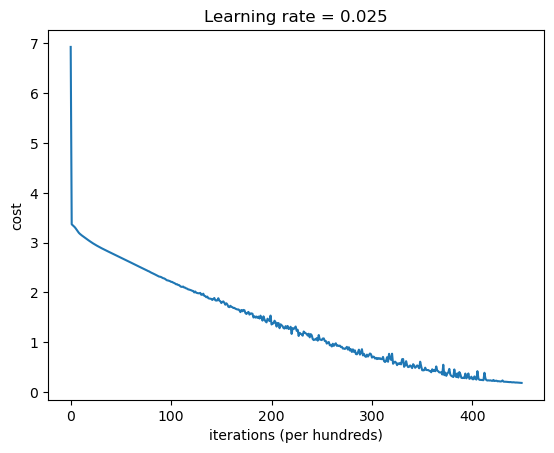

In [31]:
parameters, costs = L_LayeredModel(X_train, Y_train, [X_train.shape[0],256,10], learning_rate=0.025, num_iterations = 45000, print_cost = True)

In [32]:
Y_test_bonus = predict(X_test_bonus, parameters)
Y_test_bonus

array([3, 6, 3, 6, 0, 6, 0, 6, 6, 9], dtype=int64)